In [1]:
import os
import pandas as pd
import spacy
import statistics
from collections import Counter
from nltk.corpus import stopwords
from nltk import pos_tag
import nltk
import nltk.tokenize 
import re
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def get_basic_statistics(dataset_path,language):
    print("Basic statistics of dataset: ", dataset_path)
    print()
    
    if language == 'en':
        nlp_en = spacy.load('en_core_web_sm')
    if language == 'nl':
        nlp_nl = spacy.load('nl_core_news_sm')
    
    #read in csv
    if language == 'en':
        csv_file = dataset_path
        articles = pd.read_csv(csv_file, sep=",", header=0)
    if language == 'nl':
        csv_file = dataset_path
        articles = pd.read_csv(csv_file, sep=",", header=0, encoding="unicode_escape")       
    
    # get the shape of the article
    print("Shape of the article dataframe: ", articles.shape)
    print()
    
    # do this to print out entire dataframe
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    
    # describe the articles
    print("Properties of the dataset:")
    print(articles.describe())
    print()
    
    # Length of the titles (in characters and tokens)
    lengths = []
    tokens = []
    for title in articles["title"]:
        lengths.append(len(title))
        tokens.append(len(title.split()))
        
    # in characters:
    mean = statistics.mean(lengths)
    std = statistics.stdev(lengths)
    median = statistics.median(lengths)
    variance = statistics.variance(lengths)
    min_length = min(lengths)
    max_length = max(lengths)
    
    two_decimals = ["%.2f" % v for v in [mean, std, median, variance, min_length, max_length]]
    print("For article titles in characters:")
    print("Mean, Standard Deviation, Median, Variance, Minimum, Maximum")
    print(two_decimals)
    print()
    
    # in tokens:
    mean_tokens = statistics.mean(tokens)
    std_tokens = statistics.stdev(tokens)
    median_tokens = statistics.median(tokens)
    variance_tokens = statistics.variance(tokens)
    min_length_tokens = min(tokens)
    max_length_tokens = max(tokens)
    
    two_decimals_tokens = ["%.2f" % v for v in
                           [mean_tokens, std_tokens, median_tokens, variance_tokens, min_length_tokens,
                            max_length_tokens]]
    print("For article titles in tokens:")
    print("Mean, Standard Deviation, Median, Variance, Minimum, Maximum")
    print(two_decimals_tokens)
    print()
    
    # process the texts using spacy
    processed_articles = []

    if language == 'nl':
        for i in articles["content"]:
            processed_articles.append(nlp_nl(i))
    else:
        for i in articles["content"]:
            processed_articles.append(nlp_en(i))

    # get total token frequencies over all articles
    token_frequencies = Counter()
    ttr_articles = []
    
    for doc in processed_articles:
        token_frequencies_article = Counter()

        all_tokens = [str(token).lower() for token in doc]
        token_frequencies.update(all_tokens)
        token_frequencies_article.update(all_tokens)

        num_types = len(token_frequencies_article.keys())
        num_tokens = sum(token_frequencies_article.values())

        tt_ratio = num_types / num_tokens
        ttr_articles.append(tt_ratio)
    
    # of type-token ratio:
    mean_ttr = statistics.mean(ttr_articles)
    std_ttr = statistics.stdev(ttr_articles)
    median_ttr = statistics.median(ttr_articles)
    variance_ttr = statistics.variance(ttr_articles)
    min_length_ttr = min(ttr_articles)
    max_length_ttr = max(ttr_articles)

    two_decimals_ttr = ["%.2f" % v for v in
                        [mean_ttr, std_ttr, median_ttr, variance_ttr, min_length_ttr, max_length_ttr]]
    print("For type-token ratio of articles:")
    print("Mean, Standard Deviation, Median, Variance, Minimum, Maximum")
    print(two_decimals_ttr)
    print()

    print("Most common words in this dataset:")
    print(token_frequencies.most_common(50))
    print()
    
    # get total token frequencies over all articles- cleaned（so remove stopwords and punctuation）
    # stopwords needs to be downloaded

    # load stopwords:
    if language == 'en':
        stopwords_1 = set(stopwords.words('english'))
        new_words = ["'s","s","1","_"]
        stopwords_en = stopwords_1.union(new_words)
    else:
        stopwords_nl = stopwords.words('dutch')

    if language == 'nl':
        token_frequencies = Counter()

        for doc in processed_articles:
            token_frequencies_article = Counter()

            all_tokens = []

            for token in doc:
                token = token.text.lower()

                if token not in stopwords_nl:
                    token = re.sub(r'[^\w]', '', token)
                    if token != '':
                        all_tokens.append(token)

            token_frequencies.update(all_tokens)
            token_frequencies_article.update(all_tokens)

        print("Most common content words, stopwords and punctuation removed:")
        print(token_frequencies.most_common(50))
        print()
    
    else:
        token_frequencies = Counter()

        for doc in processed_articles:
            token_frequencies_article = Counter()

            all_tokens = []

            for token in doc:
                token = token.text.lower()

                if token not in stopwords_en:
                    token = re.sub(r'[^\w]', '', token)
                    if token != '':
                        all_tokens.append(token)

            token_frequencies.update(all_tokens)
            token_frequencies_article.update(all_tokens)

        print("Most common content words in this dataset, stopwords and punctuation removed:")
        print(token_frequencies.most_common(50))
        print()
        
    x_content_words = [x[1] for x in token_frequencies.most_common(20)]
    y_content_words = [y[0] for y in token_frequencies.most_common(20)]

    figure, ax = plt.subplots(figsize=(10, 5))

    # make a bar chart using seaborn
    most_common_chart = sns.barplot(x=x_content_words, y=y_content_words, palette='Set1', ax=ax)

    if language == 'en':
        most_common_chart.set(title='Most Common Content Words in Development data (English)', xlabel="Frequency of word", ylabel="Content word")
    else:
        most_common_chart.set(title='Most Common Content Words in Dutch Dataset', xlabel="Frequency of word", ylabel="Content word")

    fig = most_common_chart.get_figure()
    fig.savefig("most_common_" + language + ".png", dpi=300)

    # get total lemma frequencies over all articles
    if language == 'nl':

        lemma_frequencies = Counter()

        for doc in processed_articles:
            all_lemmas = []

            for token in doc:
                lemma = token.lemma_.lower()

                if lemma not in stopwords_nl:
                    lemma = re.sub(r'[^\w]', '', lemma)
                    if lemma != '':
                        all_lemmas.append(lemma)

            lemma_frequencies.update(all_lemmas)

        print("Most common content lemmas:")
        print(lemma_frequencies.most_common(50))
        print()

    else:

        lemma_frequencies = Counter()

        for doc in processed_articles:
            all_lemmas = []

            for token in doc:
                lemma = token.lemma_.lower()

                if lemma not in stopwords_en:
                    lemma = re.sub(r'[^\w]', '', lemma)
                    if lemma != '':
                        all_lemmas.append(lemma)

            lemma_frequencies.update(all_lemmas)

        print("Most common content lemmas:")
        print(lemma_frequencies.most_common(50))
        print()

    figure, ax = plt.subplots(figsize=(14, 4))

    # make a bar chart using seaborn
    x_lemmas = [x[1] for x in lemma_frequencies.most_common(20)]
    y_lemmas = [y[0] for y in lemma_frequencies.most_common(20)]

    most_lemmas_chart = sns.barplot(x=x_lemmas, y=y_lemmas, palette='Set1', ax=ax)

    if language == 'en':
        most_lemmas_chart.set(title='Most Common Lemmas in Development data (English)', xlabel="Frequency of lemma",
                              ylabel="Lemma")
    else:
        most_lemmas_chart.set(title='Most Common Lemmas in Dutch Dataset', xlabel="Frequency of lemma",
                              ylabel="Lemma")

    fig = most_lemmas_chart.get_figure()
    fig.savefig("most_lemmas_" + language + ".png", dpi=300)
    
    # get total noun lemma frequencies over all articles
    if language == 'nl':

        lemma_frequencies = Counter()

        for doc in processed_articles:
            all_lemmas = []

            for token in doc:
                lemma = token.lemma_.lower()

                if lemma not in stopwords_nl:
                    lemma = re.sub(r'[^\w]', '', lemma)
                    if lemma != '':
                        all_lemmas.append(lemma)

            lemma_frequencies.update(all_lemmas)

        print("Most common content lemmas:")
        print(lemma_frequencies.most_common(50))
        print()

    else:

        noun_lemma_frequencies = Counter()

        for doc in processed_articles:
            all_noun_lemmas = []

            for token in doc:
                tagged_token = token.pos_
                if tagged_token == 'NOUN':
                    lemma = token.lemma_.lower()
                    if lemma not in stopwords_en:
                        lemma = re.sub(r'[^\w]', '', lemma)
                        if lemma != '':
                            all_noun_lemmas.append(lemma)

                noun_lemma_frequencies.update(all_lemmas)

        print("Most common noun lemmas:")
        print(noun_lemma_frequencies.most_common(50))
        print()

        figure, ax = plt.subplots(figsize=(14, 4))

        # make a bar chart using seaborn
        x_lemmas = [x[1] for x in noun_lemma_frequencies.most_common(20)]
        y_lemmas = [y[0] for y in noun_lemma_frequencies.most_common(20)]

        most_lemmas_chart = sns.barplot(x=x_lemmas, y=y_lemmas, palette='Set1', ax=ax)

        if language == 'en':
            most_lemmas_chart.set(title='Most Common Noun Lemmas in English Dataset', xlabel="Frequency of lemma",
                              ylabel="Lemma")
        else:
            most_lemmas_chart.set(title='Most Common Noun Lemmas in Dutch Dataset', xlabel="Frequency of lemma",
                              ylabel="Lemma")

        fig = most_lemmas_chart.get_figure()
        fig.savefig("most_Noun_lemmas_" + language + ".png", dpi=300)
    
    

Basic statistics of dataset:  ../data/dev_data.csv

Shape of the article dataframe:  (292, 6)

Properties of the dataset:
               id
count  292.000000
mean   146.500000
std     84.437354
min      1.000000
25%     73.750000
50%    146.500000
75%    219.250000
max    292.000000

For article titles in characters:
Mean, Standard Deviation, Median, Variance, Minimum, Maximum
['27.00', '14.97', '24.00', '224.23', '4.00', '70.00']

For article titles in tokens:
Mean, Standard Deviation, Median, Variance, Minimum, Maximum
['3.84', '2.35', '3.00', '5.51', '1.00', '13.00']

For type-token ratio of articles:
Mean, Standard Deviation, Median, Variance, Minimum, Maximum
['0.44', '0.08', '0.43', '0.01', '0.26', '0.67']

Most common words in this dataset:
[('the', 6738), ('.', 4479), ('of', 3643), (',', 3028), ('a', 2514), ('is', 2242), ('to', 2180), ('in', 2043), ('and', 1999), ('are', 1071), ('-', 816), ('be', 785), (')', 755), ('for', 726), (':', 710), ('(', 680), ('can', 670), ('that', 655

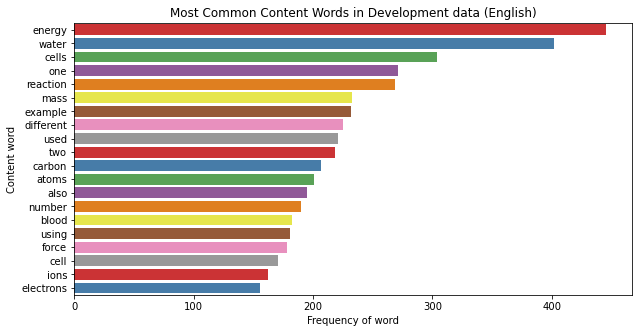

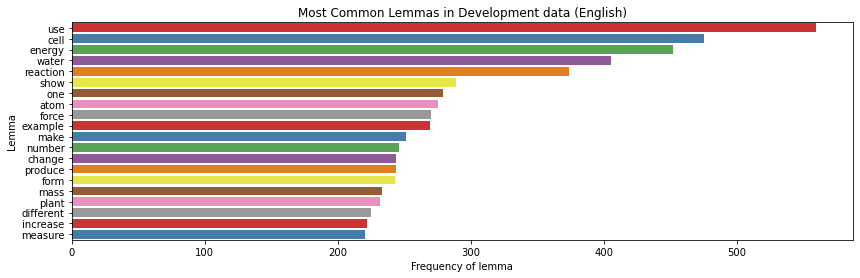

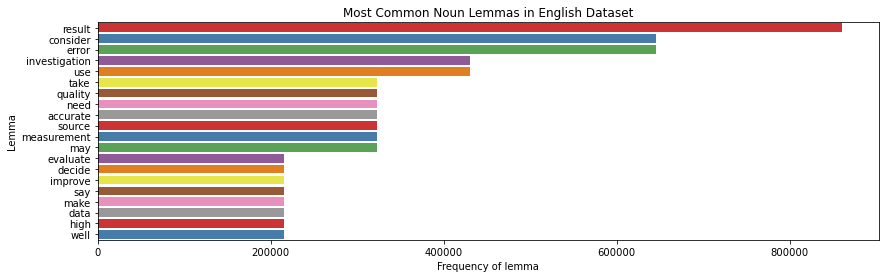

In [3]:
get_basic_statistics('../data/dev_data.csv','en')

Basic statistics of dataset:  ../data/test_data.csv

Shape of the article dataframe:  (54, 6)

Properties of the dataset:
                                  title   chapter  \
count                                54        43   
unique                               25        35   
top     Cursus A - Geesteswetenschappen  Websites   
freq                                  8         2   

                                                  content  \
count                                                  54   
unique                                                 52   
top     Deze_ibGuide_nformatievaardigheden is bedoeld ...   
freq                                                    2   

                                          gold_label                bl_label  \
count                                             54                      54   
unique                                            22                      14   
top     Selecteren informatiebronnen en zoeksystemen  Informatieva

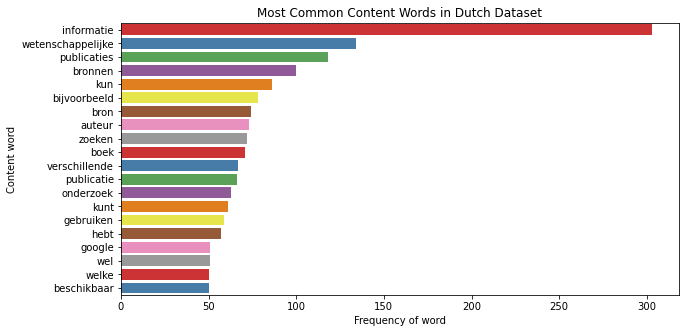

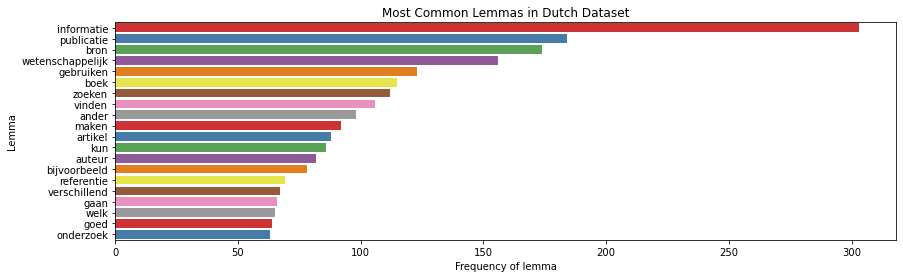

In [4]:
get_basic_statistics('../data/test_data.csv','nl')